In [1]:
import os
import gzip
import numpy as np
import pandas as pd
import time
import datetime
import cPickle as pickle
from matplotlib.pylab import subplots
import matplotlib.pylab as mpylab
import matplotlib.ticker as mticker

In [2]:
def UTC_to_UnixTime(dt):
    '''
    Given a UTC time, find the Unix time

    :param dt, UTC datetime
    :type message: datetime.datetime
    :returns: Unix time of the UTC datetime, like 1200835411
    :type returns: int
    '''
    return int((dt - datetime.datetime(1970,1,1)).total_seconds())

def UnixTime_to_UTC(timestamp):

    '''
    converts Unix time to UTC time
    
    :param timestamp: unix timestamp
    :type timestamp: int 
    :return corresponding date and time
    :type: datetime.datetime
    '''
    # can show it use .strftime('%Y-%m-%d %H:%M:%S')
    return datetime.datetime.utcfromtimestamp(int(timestamp))


def find_age_index(age, ages):
    '''
    find index of age inteval in age_intervals that the age is in 
    :param age: user age
    :type age: int 
    :param ages: a list of age
    :type ages: list 
    :return index of age in ages, if age is not in ages, return -1
    :type: int
    '''
    for i in range(len(ages)):
        if age == ages[i]:
            return i
    # age is not in ages
    return -1

In [3]:
MBID_dictionary = pickle.load(open('../Cleared Data/MBID_dictionary.p','rb'))
df_demographics = pd.read_csv('../Cleared Data/MLHD_demographics_scrobble.csv', delimiter = '\t')
df_demographics.head()

,uuid,age,country,gender,registered,firstscrobble,lastscrobble
0,dfb7ea9d-6e4f-48e4-96f6-59abcc207d55,30.0,AT,n,1035849600,1138630578,1362652343
1,a89cb9c5-ba84-424e-8950-16657bb6f7af,35.0,US,m,1035849600,1130274207,1369498564
2,dde6c339-c256-43f1-94e8-02f4043abdf9,35.0,UK,m,1035849600,1108340306,1357866969
3,44d70878-6e9a-432f-831d-179e8354f448,40.0,DK,n,1035849600,1368342035,1126011087
4,e553ab79-5e93-48fc-aa63-1c4319cafd23,NaN,SE,n,1035849600,1189263203,1357317882


In [7]:
def listeners_vs_age_for_genres(genres, ages, path, start_UnixTime, end_UnixTime):
    '''
    In some time period, for several genres， count the number of listeners of different ages
    
    :param genres, a list of genres selected
    :type message: list
    :param ages, a list of ages selected, with format [age, ]
    :type message: list
    :param path, a string represents path to the diretory that contains user dataset 
    :type message: str
    :param start_UnixTime, the unix time of start of period we used
    :type message: int
    :param end_UnixTime, the unix time of end of period we used 
    :type message: int
    :returns: a dictionary contains all the statistics information, with format 
    {genres: (ages, #listeners)}
    :type returns: dict
    
    Global variable df_demographics and MBID_dictionary are used
    '''
    
    # data format, dictionaries: {genres: (ages, #listeners)} 
    # initialization of dictionary
    statistics = {}
    for genre in genres:
        statistics[genre] = (ages, [0] * len(ages))
    
    # number of files we go through
    for filename in os.listdir(path): # iterate over all user files
        # user file has file name: uuid.txt.gz
        if 'gz' in filename:
            with gzip.open(path + '/' + filename) as f:
                # clearing the data
                user = pd.read_csv(f, delimiter = '\t', header = None)
                user = user.drop([2,3],axis=1) 
                user = user.dropna()
                user.columns = ['time', 'artist_MBID']


                '''
                one user can only be counted once for one age of every genre
                so we use tag_added to denote whether one user is added as a listener
                for a genre of some period 
                
                tag_added has format {genre: list of booleans, }
                tag_added[genre][i] == True indicates that this user has been added as 
                a listener for genre of ages[i]. False indicates hasn't been added.
                '''
                tag_added = {}
                for genre in genres:
                    tag_added[genre] =  [False] * len(ages)
                    
                user_uuid = filename[:-7]
                user_demographics = df_demographics[df_demographics.uuid == user_uuid]
                user_demographics_dropna = user_demographics.dropna()

                for i in range(user.shape[0]): #iterate all logs in one user file
                    # only use data in [start_UnixTime, end_UnixTime] period
                    if start_UnixTime <= user.iat[i,0] <= end_UnixTime:
                        '''
                        compute user's age which changes with time. We think age shown 
                        in MLHD_demographics_scrobble.csv is the age of the user when he 
                        registered
                        '''
                        if user_demographics_dropna.shape[0] > 0:
                            user_age = int(user_demographics_dropna.iat[0,1] \
                                           - UnixTime_to_UTC(user_demographics_dropna.iat[0,4]).year \
                                           + UnixTime_to_UTC(user.iat[i,0]).year)
                        else:
                            # case that we cannot extract the user's age
                            user_age = -1

                        age_index = find_age_index(user_age, ages)
                        if age_index != -1:
                            if user.iat[i,1] in MBID_dictionary:
                                taglist = MBID_dictionary[user.iat[i,1]]
                                for tag in taglist: 
                                    for genre in genres:
                                        # tag can be something like 'hardrock' and 'pop/rock'
                                        if genre in tag and not tag_added[genre][age_index]:
                                            statistics[genre][1][age_index] += 1
                                            tag_added[genre][age_index] = True
    
    return statistics

In [5]:
def plot_listeners_vs_age_for_genres(statistics, agemin=0, agemax=100):
    '''
    User statistical information produced in statistics_3(genres, ages, path, start_UnixTime, end_UnixTime) 
    and plot correspoding graph, for several genres，the number of listeners vs age
    
    :param statistics, the output of statistics_3(genres, ages, path, start_UnixTime, end_UnixTime), 
    a dictionary of format: {genres: (ages, #listeners)}
    :type statistics: dict
    :param agemin, the small bound of x we plot
    :type message: int
    :param agemax, the large bound of x we plot
    :type message: int
    :returns: no return
    
    '''
    
    fig,ax = subplots()
    for genre in iter(statistics):
        ax.plot(statistics[genre][0], statistics[genre][1], label = genre)


    ax.legend(loc='best')
    ax.set_xlabel('age')
    ax.set_ylabel('number of listeners')
    ax.set_title('number of listeners vs age for different genres',fontsize=14)
    ax.set_xlim(agemin, agemax)

    # format the ticks
    ax.xaxis.set_major_locator(mticker.IndexLocator(5, -1))
    ax.xaxis.set_minor_locator(mticker.IndexLocator(1, 1))
    #ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    fig.show()
    mpylab.savefig('../Images/listeners_vs_age_for_genres_(%d, %d).png' \
                   %(agemin, agemax), bbox_inches='tight')

    return

In [8]:
'''
Plot how number of listeners change with their ages for selected genres.
We use 1000 user files.  

When you run codes, please change path, which is the local directory 
that you store user tar file, i.e. 'MLHD_000.tar'
'''
path = '/Users/yjt/Downloads'

# ages = [1, 2, 3,..., 100]
ages = [i + 1 for i in range(100)]
    
# we only use data of some period from start_UnixTime to end_UnixTime
start_datetime = datetime.datetime(2009,1,1)
end_datetime = datetime.datetime(2012,1,1)
start_UnixTime = UTC_to_UnixTime(start_datetime)
end_UnixTime = UTC_to_UnixTime(end_datetime)

genres = ['pop', 'rock', 'jazz', 'folk', 'blue', 'kpop', 'hiphop', 'disco'] # list of genres
user_file_path = path + '/MLHD_000'

start_time = time.time()
statistics = listeners_vs_age_for_genres(genres, ages, user_file_path, start_UnixTime, end_UnixTime)
print("--- %s seconds ---" % (time.time() - start_time)) 


--- 1665.46992302 seconds ---


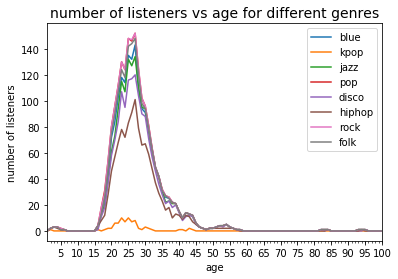

In [11]:
# plot graph listeners_vs_age_for_genres
agemin = 1
agemax = 100
plot_listeners_vs_age_for_genres(statistics,agemin,agemax)

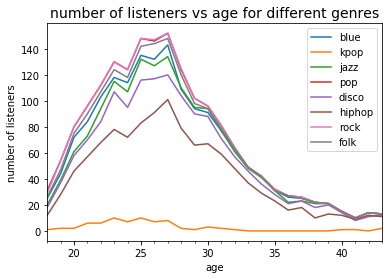

In [12]:
agemin = 18
agemax = 43
plot_listeners_vs_age_for_genres(statistics,agemin,agemax)